In [109]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
import pickle
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from collections import Counter
import nltk
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import stopwords
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
from sklearn.metrics import precision_score, recall_score


%matplotlib inline
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [104]:
df = pd.read_csv('/content/data.csv')

In [105]:
def clean(text):
    port = PorterStemmer()
    stopword = nltk.corpus.stopwords.words('english')
    tokens = nltk.word_tokenize(text)
    lower = [word.lower() for word in tokens]
    no_stopwords = [word for word in lower if word not in stopword]
    no_alpha = [word for word in no_stopwords if word.isalpha()]
    lemm_text = [port.stem(word) for word in no_alpha]
    clean_text = lemm_text
    return ' '.join(word for word in clean_text)

In [106]:

clean_df = df
for i in range(len(df['Sentence'])):
    clean_df['Sentence'][i] = clean(df['Sentence'][i])

def show_cloud(sentiment):
    allwords = ' '.join(word for word in clean_df[clean_df['Sentiment'] == sentiment]['Sentence'])
    wordcloud = WordCloud(width=500, height=300, max_font_size=100, stopwords=stopwords.words('english')).generate(allwords)
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

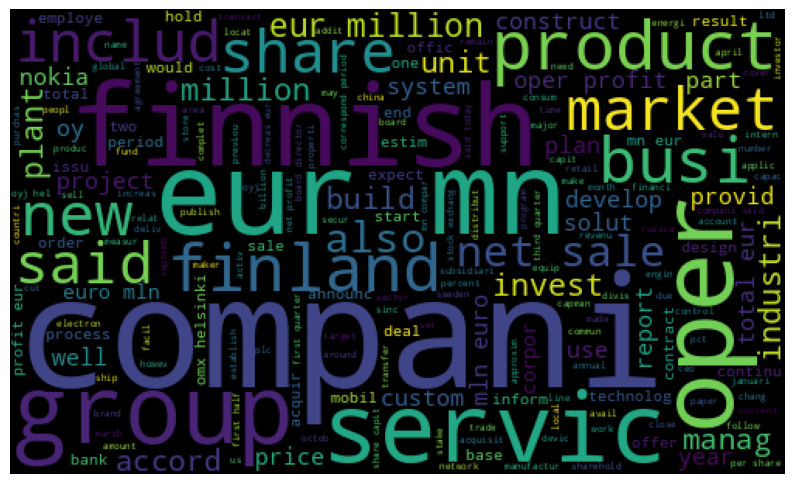

In [91]:
show_cloud('neutral')

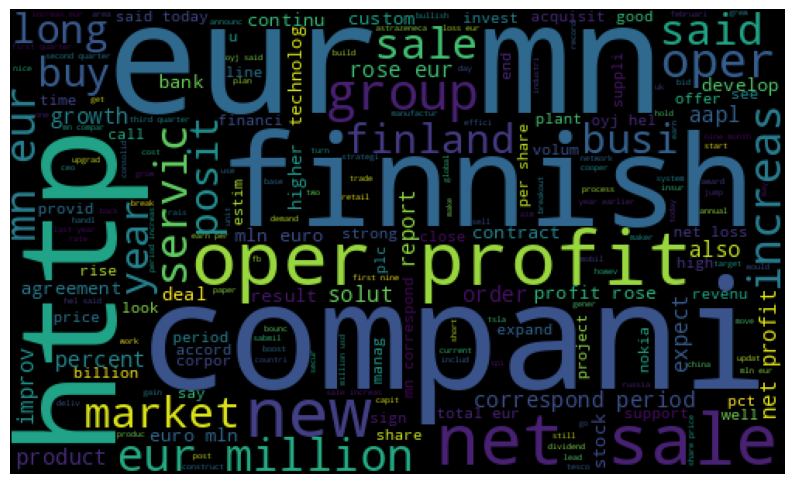

In [90]:
show_cloud('positive')

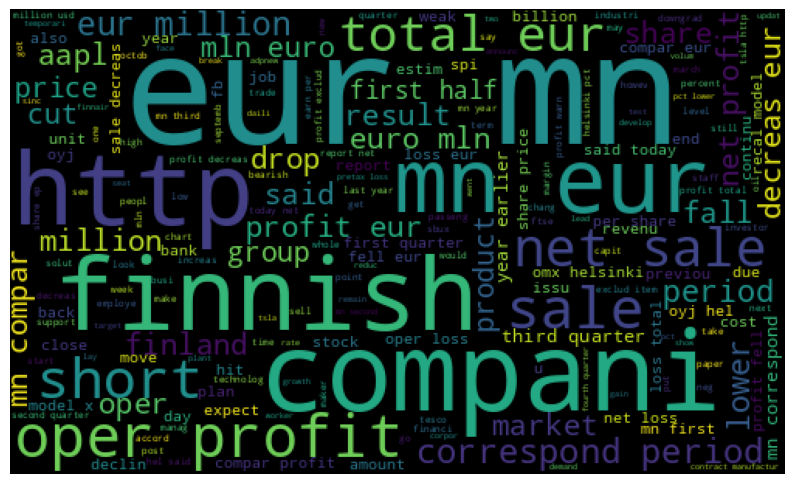

In [89]:
show_cloud('negative')

In [114]:
def extract_postags(text):
    tokens = nltk.word_tokenize(text)
    return [tag for word, tag in nltk.pos_tag(tokens)]

In [121]:
def join_postags(postags):
    return ' '.join(postags)
clean_df['postags'] = clean_df['Sentence'].apply(extract_postags)
clean_df['postags_str'] = clean_df['postags'].apply(join_postags)
clean_df['text_postags'] = clean_df['Sentence'] + ' ' + clean_df['postags_str']
clean_df['Sentiment'] = clean_df['Sentiment'].replace({'neutral': 0, 'positive': 1, 'negative': -1})
y = clean_df['Sentiment']
tfid = TfidfVectorizer()
X_final = tfid.fit_transform(clean_df['text_postags'])

In [122]:
smote = SMOTE()
x_sm,y_sm = smote.fit_resample(X_final,y)
print(y_sm)
print(x_sm)

0       1
1      -1
2       1
3       0
4       0
       ..
9385    1
9386    1
9387    1
9388    1
9389    1
Name: Sentiment, Length: 9390, dtype: int64
  (0, 3150)	0.06458283622272852
  (0, 2396)	0.10846818393176111
  (0, 6780)	0.06209411543736305
  (0, 4207)	0.46848145416693
  (0, 3976)	0.16186617853473356
  (0, 1199)	0.16977371802614716
  (0, 4805)	0.16005318674611788
  (0, 4159)	0.11282497491769274
  (0, 1300)	0.17740500315458907
  (0, 4072)	0.2277773123232502
  (0, 5167)	0.21663226137367114
  (0, 4713)	0.1933425192117745
  (0, 1208)	0.14684328918658535
  (0, 5565)	0.21239510965276714
  (0, 542)	0.14312772954437236
  (0, 3606)	0.3303637788266787
  (0, 4928)	0.13024822457307375
  (0, 5854)	0.13024822457307375
  (0, 2526)	0.21663226137367114
  (0, 611)	0.20548721042409213
  (0, 3526)	0.2277773123232502
  (0, 6288)	0.26996849604553536
  (0, 2457)	0.23568485181466375
  (1, 5060)	0.15031141427544592
  (1, 4789)	0.40649637111225984
  :	:
  (9388, 4208)	0.27500678202885587
  (9388, 4207)

In [138]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

X_train , X_test , y_train , y_test = train_test_split(x_sm , y_sm , test_size=0.1,random_state=3)
random_forest_classifier = RandomForestClassifier()
random_forest_classifier.fit(X_train,y_train.values.ravel())
y_pred = random_forest_classifier.predict(X_test)
accuracy = round(accuracy_score(y_test, y_pred), 3)
precision = round(precision_score(y_test, y_pred, average='micro'), 3)
recall = round(recall_score(y_test, y_pred, average='micro'), 3)

print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)


Accuracy:  0.785
Precision:  0.785
Recall:  0.785


In [72]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(random_forest_classifier,X_train,y_train.values.ravel(),cv=5)

In [73]:
print(scores)
scores.mean()

[0.79183915 0.78106509 0.79230769 0.7964497  0.77988166]


0.7883086580889429

In [140]:
def classify_text(text):
    clean_text = clean(text)
    postags = extract_postags(clean_text)
    postags_str = join_postags(postags)
    text_postags = clean_text + ' ' + postags_str
    X_final = tfid.transform([text_postags])
    prediction = random_forest_classifier.predict(X_final)
    return prediction

In [145]:
classify_text('The Swedish buyout company has successfully divested its remaining 22.4 percent stake, marking a major and significant milestone nearly eighteen months after taking the company public in Finland.')

array([0])